In [ ]:
!pip install cartopy
# Import packages
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

from google.colab import drive
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, silhouette_score


# Connect to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# List of file paths
# ATom-1 (Jul-Aug 2016), ATom-2 (Jan-Feb 2017), ATom-3 (Sep-Oct 2017), and ATom-4 (Apr-May 2018)
# Summer, Winter, Fall, Spring
file_paths = [
    '/content/drive/MyDrive/UCLA/AOS_C204/Final_Project_Data/MER-1HZ_DC8_ATom-1.nc',
    '/content/drive/MyDrive/UCLA/AOS_C204/Final_Project_Data/MER-1HZ_DC8_ATom-2.nc',
    '/content/drive/MyDrive/UCLA/AOS_C204/Final_Project_Data/MER-1HZ_DC8_ATom-3.nc',
    '/content/drive/MyDrive/UCLA/AOS_C204/Final_Project_Data/MER-1HZ_DC8_ATom-4.nc'
]

seasons = ['Summer', 'Winter', 'Fall', 'Spring']

# Initialize empty lists to store datasets and seasons
df_list = []
mms_list = []
hk_list = []
DLH_H2O_list = []
NAerosol_list = []
NCoarseAerosol_list = []
cloud_indicator_list = []
season_list = []


# Loop through each file path and corresponding season
for file_path, season in zip(file_paths, seasons):
    # Open data
    ds = xr.open_dataset(file_path)
    # Convert to DataFrame
    df = ds.to_dataframe()
    df_list.append(df)

    # Open MMS data
    mms = xr.open_dataset(file_path, group='MMS')
    # Convert to DataFrame
    mmsf = mms.to_dataframe()
    mms_list.append(mmsf)

    # Open housekeeping data
    Hskping = xr.open_dataset(file_path, group='Hskping')
    # Convert to DataFrame
    Hskping = Hskping.to_dataframe()
    hk_list.append(Hskping)

    # Open DLH data
    DLH_H2O = xr.open_dataset(file_path, group='DLH-H2O')
    # Convert to DataFrame
    DLH_H2O = DLH_H2O.to_dataframe()
    DLH_H2O_list.append(DLH_H2O)

    # Open Naersosol data
    NAerosol = xr.open_dataset(file_path, group='NAerosol')
    # Convert to DataFrame
    NAerosol = NAerosol.to_dataframe()
    NAerosol_list.append(NAerosol)

    # Open Ncoarseaerosol data
    NCoarseAerosol = xr.open_dataset(file_path, group='NCoarseAerosol')
    # Convert to DataFrame
    NCoarseAerosol = NCoarseAerosol.to_dataframe()
    NCoarseAerosol_list.append(NCoarseAerosol)

    # Open Cloudindicator data
    cloud_indicator = xr.open_dataset(file_path, group='Cloudindicator')
    # Convert to DataFrame
    cloud_indicator = cloud_indicator.to_dataframe()
    cloud_indicator_list.append(cloud_indicator)

    # Add season label to the list
    season_list += [season] * len(ds['time'])

In [ ]:
# Set up variables
# Access time coordinate in the df_list
time_dfs = [df.to_xarray()['time'].to_dataframe() for df in df_list]
# Concatenate time coordinates into a 1D DataFrame
time_df = pd.concat(time_dfs, ignore_index=True)
time_df['day'] = time_df['time'].dt.day
time_df['month'] = time_df['time'].dt.month
time_df['year'] = time_df['time'].dt.year
# Drop the original 'time' column
time_df = time_df.drop(columns=['time'])

# Convert specific variables from each DataFrame into a 1D DataFrame in mms_list
latitude_df = pd.concat([mmsf[['G_LAT']] for mmsf in mms_list], ignore_index=True)
longitude_df = pd.concat([mmsf[['G_LONG']] for mmsf in mms_list], ignore_index=True)
altitude_df = pd.concat([mmsf[['G_ALT']] for mmsf in mms_list], ignore_index=True)
w_df = pd.concat([mmsf[['W']] for mmsf in mms_list], ignore_index=True)

# Convert specific variables from each DataFrame into a 1D DataFrame in hk_list
# Relative_Humidity_df = pd.concat([Hskping[['Relative_Humidity']] for Hskping in hk_list], ignore_index=True)
Total_Air_Temp_df = pd.concat([Hskping[['Total_Air_Temp']] for Hskping in hk_list], ignore_index=True)
Sat_Vapor_Press_H2O_df = pd.concat([Hskping[['Sat_Vapor_Press_H2O']] for Hskping in hk_list], ignore_index=True)
Sat_Vapor_Press_Ice_df = pd.concat([Hskping[['Sat_Vapor_Press_Ice']] for Hskping in hk_list], ignore_index=True)
Vapor_Press_df = pd.concat([Hskping[['Part_Press_Water_Vapor']] for Hskping in hk_list], ignore_index=True)

# Convert specific variables from each DataFrame into a 1D DataFrame in hk_list
RHi_DLH_df = pd.concat([DLH_H2O[['RHi_DLH']] for DLH_H2O in DLH_H2O_list], ignore_index=True)
RHw_DLH_df = pd.concat([DLH_H2O[['RHw_DLH']] for DLH_H2O in DLH_H2O_list], ignore_index=True)

# Convert specific variables from each DataFrame into a 1D DataFrame in NAerosol_list
N_coarse_AMP_df = pd.concat([NAerosol[['N_coarse_AMP']] for NAerosol in NAerosol_list], ignore_index=True)
N_fine_AMP_df = pd.concat([NAerosol[['N_fine_AMP']] for NAerosol in NAerosol_list], ignore_index=True)
S_coarse_AMP_df = pd.concat([NAerosol[['S_coarse_AMP']] for NAerosol in NAerosol_list], ignore_index=True)
S_fine_AMP_df = pd.concat([NAerosol[['S_fine_AMP']] for NAerosol in NAerosol_list], ignore_index=True)

# Convert specific variables from each DataFrame into a 1D DataFrame in NCoarseAerosol_list
Ncoa1_CAPS_df = pd.concat([ NCoarseAerosol[['Ncoa1_CAPS']] for  NCoarseAerosol in NCoarseAerosol_list], ignore_index=True)
Ncoa2_CAPS_df = pd.concat([ NCoarseAerosol[['Ncoa2_CAPS']] for  NCoarseAerosol in NCoarseAerosol_list], ignore_index=True)
Ncoa3_CAPS_df = pd.concat([ NCoarseAerosol[['Ncoa3_CAPS']] for  NCoarseAerosol in NCoarseAerosol_list], ignore_index=True)
Ntot_CAPS_df = pd.concat([ NCoarseAerosol[['Ntot_CAPS']] for  NCoarseAerosol in NCoarseAerosol_list], ignore_index=True)

# Concatenate the Series into a 1D DataFrame cloud_indicator_list
cloud_indicator_df = pd.concat([cloud_indicator[['cloudindicator_CAPS']] for cloud_indicator in cloud_indicator_list], ignore_index=True)

# Convert season_list to a pandas Series
season_series = pd.Series(season_list, name='Season')
# Concatenate the Series into a 1D DataFrame
season_df = pd.concat([season_series], axis=1, ignore_index=True)
# Rename the column to 'season'
season_df = season_df.rename(columns={0: 'season'})

In [ ]:
# Concatenate the variables into a feature matrix X, X_aerosols, and y
X = pd.concat([time_df, season_df, latitude_df, longitude_df, altitude_df, Total_Air_Temp_df, w_df,Sat_Vapor_Press_H2O_df,
                Sat_Vapor_Press_Ice_df, N_coarse_AMP_df, N_fine_AMP_df,S_coarse_AMP_df, S_fine_AMP_df, Ntot_CAPS_df], axis=1)
y = cloud_indicator_df

# Replace -99999 with NaN in the original X DataFrame
X.replace(-99999, np.nan, inplace=True)
y.replace(-99999, np.nan, inplace=True)

# Drop NaN values after replacing -99999 with NaN
X_cleaned = X.dropna()
y_cleaned = y.dropna()

# Align the DataFrames based on common indices
common_indices = X_cleaned.index.intersection(y_cleaned.index)
X_cleaned = X_cleaned.loc[common_indices]
y_cleaned = y_cleaned.loc[common_indices]

# Define the values to keep in y_in_cloud
values_to_keep = [2, 3, 4]
# Filter rows in y_cleaned where the values are in the specified list
y_in_cloud = y_cleaned[y_cleaned['cloudindicator_CAPS'].isin(values_to_keep)]
# Filter rows in X_cleaned based on the indices of y_in_cloud
X_in_cloud = X_cleaned.loc[y_in_cloud.index]

# Define the values to keep in y_cirrus_cloud
values_to_keep = [4]
# Filter rows in y_cleaned where the values are in the specified list
y_cirrus_cloud = y_cleaned[y_cleaned['cloudindicator_CAPS'].isin(values_to_keep)]
# Filter rows in X_cleaned based on the indices of y_cleaned_filtered
X_cirrus_cloud = X_cleaned.loc[y_cirrus_cloud.index]

# print(len(X), len(y))
# print(len(X_cleaned), len(y_cleaned))
# print(len(X_in_cloud), len(y_in_cloud))
# print(len(X_cirrus_cloud), len(y_cirrus_cloud))

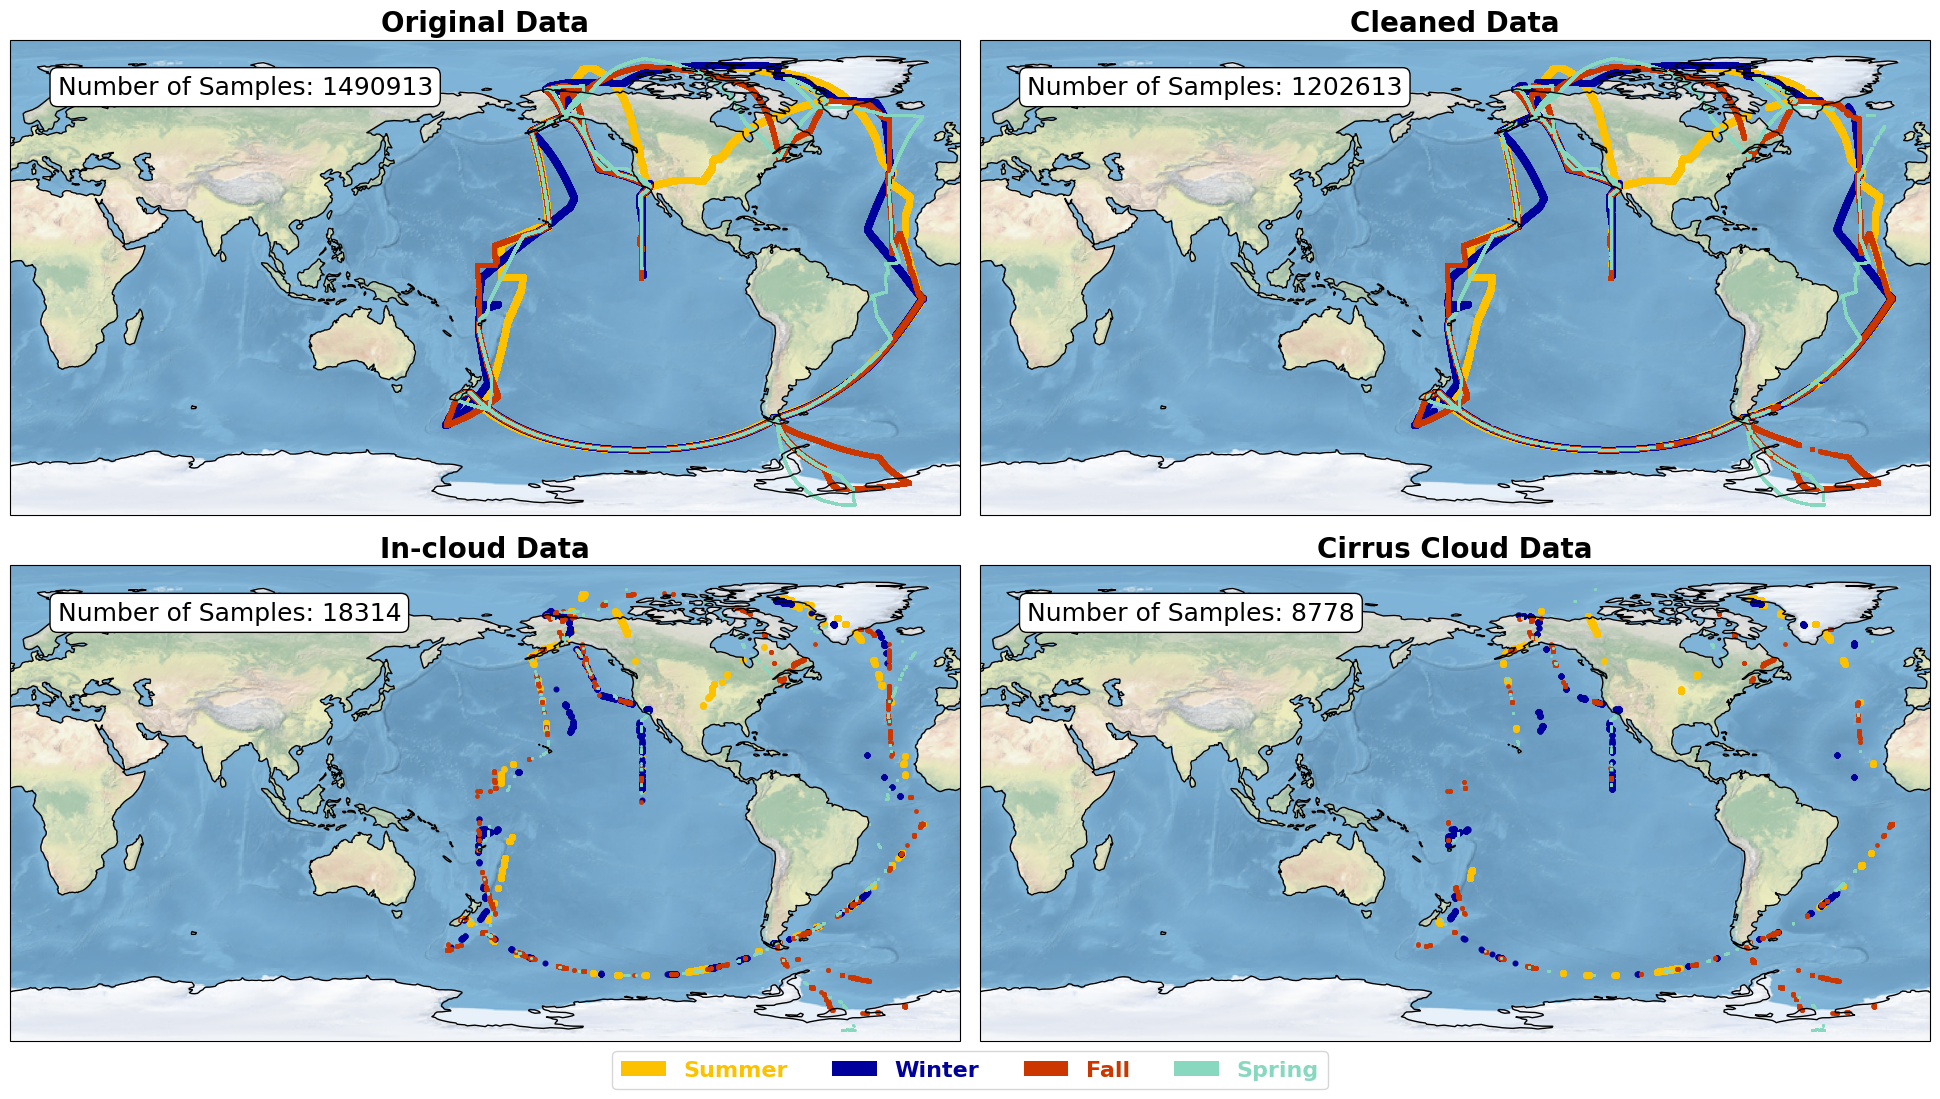

In [ ]:
# Create a dictionary to map seasons
season_color_map = {'Summer': '#fcc200',  # Yellow
                    'Winter': '#00009c',  # Dark Blue
                    'Fall': '#cc3700',    # Red Orange
                    'Spring': '#88d8c0'}  # Light Teal

season_order = ['Summer', 'Winter', 'Fall','Spring']

# Function to create a map plot
def create_map_plot(ax, longitude, latitude, season_column, season_color_map, season_order):
    # Scatter plot of points
    for i, (season, color) in enumerate(season_color_map.items()):
        # Get indices of points for the current season
        indices = (season_column == season)

        # Scatter plot for the current season with decreasing size
        sc = ax.scatter(longitude[indices], latitude[indices], c=color, label=season, s=16 - i * 5, transform=ccrs.PlateCarree())

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(24, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, gridspec_kw={'hspace': -0.6, 'wspace': 0.02})

# List to store legend handles for each subplot
legend_handles = []

for ax, data, title in zip(axs.flat, [X, X_cleaned, X_in_cloud, X_cirrus_cloud], ['Original Data', 'Cleaned Data', 'In-cloud Data', 'Cirrus Cloud Data']):
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines()
    ax.set_title(title, fontsize=20, weight='bold')  # Make the title bold

    # Scatter plot for the current data
    create_map_plot(ax, data['G_LONG'], data['G_LAT'], data['season'], season_color_map, season_order)

    # Get legend handles for the current subplot
    handles = [mpatches.Rectangle((0, 0), 1, 1, fc=season_color_map[season]) for season in season_order]
    labels = season_order
    legend_handles.extend(handles)

    # Add textbox with the number of samples in the upper left corner
    num_samples = len(data)
    text_box = f"Number of Samples: {num_samples}"
    ax.text(0.05, 0.9, text_box, fontsize=18, ha='left', va='center', transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Create a legend closer underneath the subplots
legend = fig.legend(legend_handles, season_order, fontsize=16, markerscale=0, loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=4)

# Customize legend text color and weight to match marker colors
for text, color in zip(legend.get_texts(), [season_color_map[season] for season in season_order]):
    text.set_color(color)
    text.set_weight('bold')  # Set the text weight to bold

# Adjust the spacing between subplots and the legend
plt.subplots_adjust(left=0.1, bottom=-0.96)

# Show the plot
plt.show()

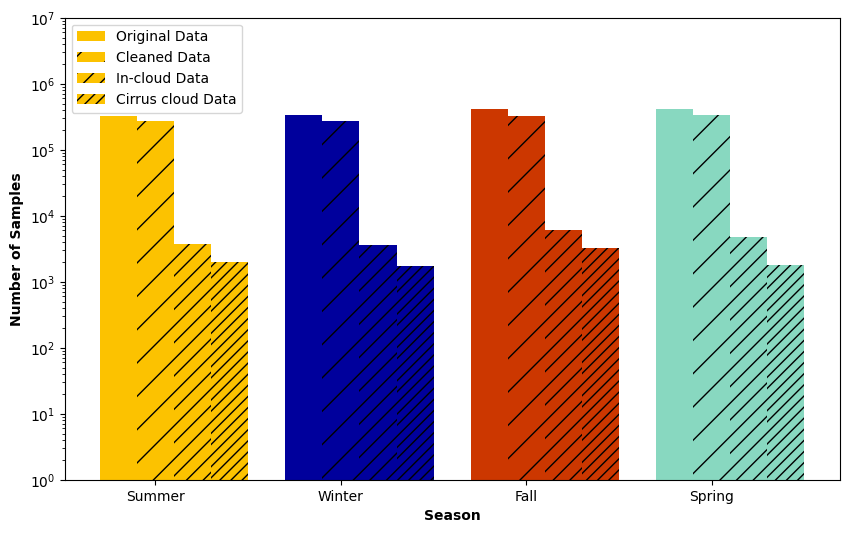

In [ ]:
# Count the number of samples in each season
season_counts = X['season'].value_counts()
season_counts_cleaned = X_cleaned['season'].value_counts()
season_counts_in_cloud = X_in_cloud['season'].value_counts()
season_counts_cirrus_cloud = X_cirrus_cloud['season'].value_counts()

# Create a bar width
bar_width = 0.2
index = np.arange(len(season_order))

# Plot grouped bars
fig, ax = plt.subplots(figsize=(10, 6))

# Original data
ax.bar(index - bar_width/2, season_counts[season_order], bar_width, color=[season_color_map[season] for season in season_order], label='Original Data')
# Cleaned data
ax.bar(index + bar_width/2, season_counts_cleaned[season_order], bar_width, color=[season_color_map[season] for season in season_order], hatch='/', label='Cleaned Data')
# Cleaned and in-cloud
ax.bar(index + 3 * bar_width/2, season_counts_in_cloud[season_order], bar_width, color=[season_color_map[season] for season in season_order], hatch='//', label='In-cloud Data')
# Cleaned and cirrus cloud
ax.bar(index + 5 * bar_width/2, season_counts_cirrus_cloud[season_order], bar_width, color=[season_color_map[season] for season in season_order], hatch='///', label='Cirrus cloud Data')

ax.set_yscale('log')  # Set y-axis to log scale
ax.set_xlabel('Season', weight='bold')
ax.set_ylabel('Number of Samples', weight='bold')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(season_order)
ax.legend()

# Set y-axis limits
ax.set_ylim(bottom=1, top=1e7)

plt.show()

In [ ]:
# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
# Encode the 'season' column in X_cleaned
X_in_cloud['season_encoded'] = label_encoder.fit_transform(X_in_cloud['season'].values.ravel())
# Train and drop the original 'season' column
X_encoded = X_in_cloud.drop(columns=['season'])
# drop all columns except for the aerosol data
X_encoded_in_cloud_aerosol = X_encoded.iloc[:, 10:15]
# print(X_encoded_in_cloud_aerosol.head())

# Scale the features
scaler = StandardScaler()
X_scaled_in_cloud_aerosol = scaler.fit_transform(X_encoded_in_cloud_aerosol)

# Make y 1d
y_1d_in_cloud = y_in_cloud.values.ravel()

In [ ]:
# Run a SVC with RBF model for predicting cloud indicator with aerosols
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_in_cloud_aerosol, y_1d_in_cloud, test_size=0.2, random_state=42)

# Create an SVC model with RBF kernel
svc_model = SVC(kernel='rbf', C=1000, gamma='scale')  # You can adjust C and gamma based on your data

# Train the model on the training data
svc_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svc_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7428337428337428
              precision    recall  f1-score   support

         2.0       0.79      0.79      0.79      1047
         3.0       0.69      0.20      0.31       796
         4.0       0.73      0.95      0.82      1820

    accuracy                           0.74      3663
   macro avg       0.74      0.65      0.64      3663
weighted avg       0.74      0.74      0.70      3663



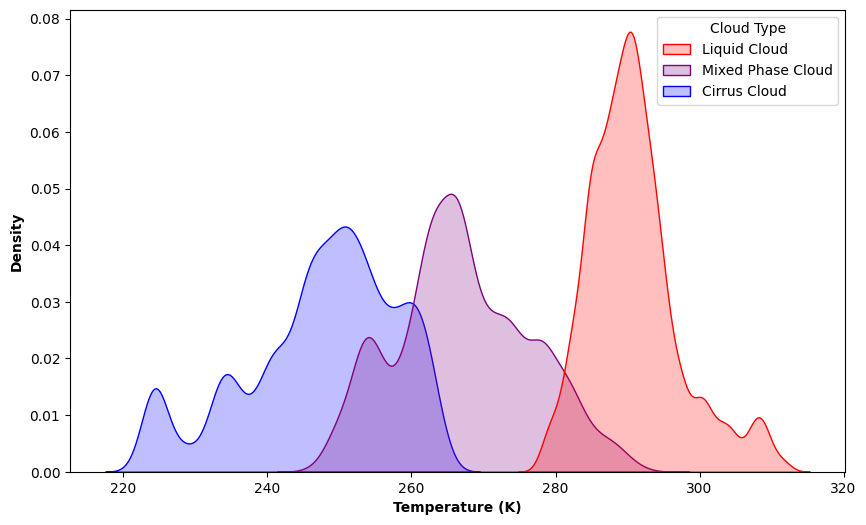

In [ ]:
# PDF that bins each cloud type by temperature
liquid_cloud_value = [2]
mixed_phase_cloud_value = [3]
# Filter rows in y_cleaned where the values are in the specified list
y_liquid_cloud = y_cleaned[y_cleaned['cloudindicator_CAPS'].isin(liquid_cloud_value)]
y_mixed_phase_cloud = y_cleaned[y_cleaned['cloudindicator_CAPS'].isin(mixed_phase_cloud_value)]

X_liquid_cloud = X_cleaned.loc[y_liquid_cloud.index]
X_mixed_phase_cloud = X_cleaned.loc[y_mixed_phase_cloud.index]

# Combine liquid and mixed-phase cloud data
X_cloud_types = pd.concat([X_liquid_cloud, X_mixed_phase_cloud, X_cirrus_cloud])
y_cloud_types = pd.concat([y_liquid_cloud, y_mixed_phase_cloud, y_cirrus_cloud])

# Add a new column for cloud types
X_cloud_types['Cloud Type'] = y_cloud_types['cloudindicator_CAPS'].apply(lambda x: 'Liquid Cloud' if x in liquid_cloud_value else ('Mixed Phase Cloud' if x in mixed_phase_cloud_value else 'Cirrus Cloud'))

# Add 273.15 to the 'Temperature' column
X_cloud_types['Total_Air_Temp'] += 273.15

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot the KDE for different cloud types binned by temperature
sns.kdeplot(data=X_cloud_types, x='Total_Air_Temp', hue='Cloud Type', fill=True, common_norm=False,
            palette={'Liquid Cloud': 'red', 'Mixed Phase Cloud': 'purple', 'Cirrus Cloud': 'blue'})

# Add labels and title
plt.xlabel('Temperature (K)',fontweight = 'bold')
plt.ylabel('Density',fontweight = 'bold')

# Show the plot
plt.show()

In [ ]:
# Add 273.15 to the 'Temperature' column to convert to Kelvin
X_cirrus_cloud['Total_Air_Temp'] += 273.15
# Encode the 'season' column in X_cleaned
X_cirrus_cloud['season_encoded'] = label_encoder.fit_transform(X_cirrus_cloud['season'].values.ravel())
# Train and drop the original 'season' column
X_encoded_cirrus_cloud = X_cirrus_cloud.drop(columns=['season'])
# drop all columns except for the aerosol data
X_encoded_cirrus_cloud = X_encoded_cirrus_cloud.iloc[:,6:15]
# Standardize
scaler = StandardScaler()
X_standardized_cirrus_cloud = scaler.fit_transform(X_encoded_cirrus_cloud)

# print(X_encoded_cirrus_cloud.head())

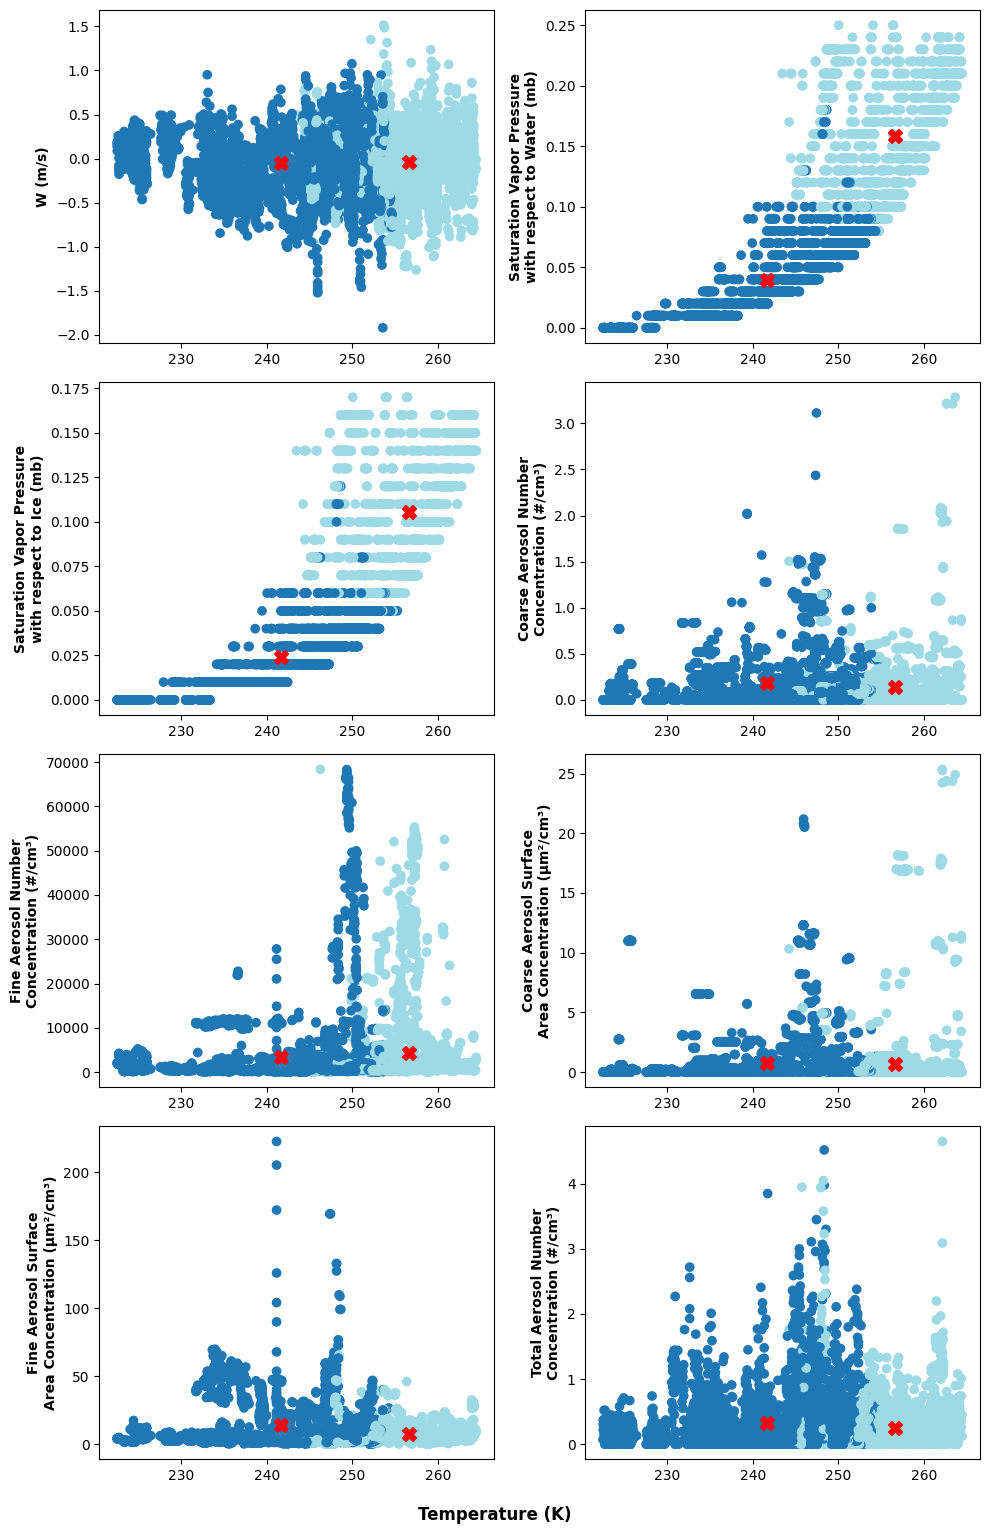

In [ ]:
# Kmeans clustering model
num_clusters = 2
# Create KMeans instance
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=1000, n_init='auto')

# Fit the model
kmeans.fit(X_standardized_cirrus_cloud)

# Get cluster assignments for each data point
cluster_labels = kmeans.labels_

# Inverse transform the standardized data to get the original scale
X_unscaled_cirrus_cloud = scaler.inverse_transform(X_standardized_cirrus_cloud)

# Inverse transform the cluster centroids to get their original scale
centroids_unscaled = scaler.inverse_transform(kmeans.cluster_centers_)

# Get the number of features
num_features = X_unscaled_cirrus_cloud.shape[1]

# List of feature names
feature_names = ['Temperature','W (m/s)', 'Saturation Vapor Pressure with respect to Water (mb)',
                 'Saturation Vapor Pressure with respect to Ice (mb)', 'Coarse Aerosol Number Concentration (#/cm³)',
                 'Fine Aerosol Number Concentration (#/cm³)', 'Coarse Aerosol Surface Area Concentration (μm²/cm³)',
                 'Fine Aerosol Surface Area Concentration (μm²/cm³)', 'Total Aerosol Number Concentration (#/cm³)']

# Create subplots
fig, axs = plt.subplots(4,2, figsize=(10, 16))

# Flatten axs
axs = axs.flatten()

# Loop through each feature (starting from the second one)
for i in range(1, num_features):
    # Scatter plot for each feature with respect to the first one
    axs[i-1].scatter(X_unscaled_cirrus_cloud[:, 0], X_unscaled_cirrus_cloud[:, i], c=cluster_labels, cmap='tab20')
    axs[i-1].scatter(centroids_unscaled[:, 0], centroids_unscaled[:, i], s=100, c='Red', marker='X', label='Centroids')

    # Set y-label with a line break after 3 words
    feature_label = feature_names[i]
    words = feature_label.split(' ')
    if len(words) > 3:
        feature_label = ' '.join(words[:3]) + '\n' + ' '.join(words[3:])
    axs[i-1].set_ylabel(f'{feature_label}', weight='bold', wrap=True)

# Add a single x-label centered below the subplots
fig.supxlabel('Temperature (K)', weight='bold', va='center')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [ ]:
# Evaluate the Kmeans with a silhouette_score
s_score = silhouette_score(X_standardized_cirrus_cloud, cluster_labels)
print(f'Silhouette score for K-means clustering: {s_score}')

Silhouette score for K-means clustering: 0.25989697325983735


Text(0, 0.5, 'Density')

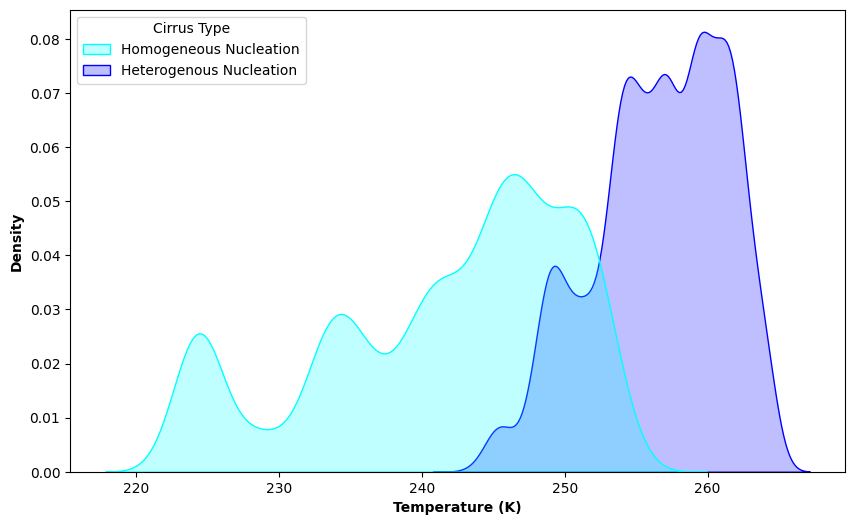

In [ ]:
# Add K-means cluster labels as column
X_cirrus_cloud[f'Kmeans_label'] = cluster_labels

cirrus_1 = [0]
cirrus_2 = [1]

# Filter rows in X_cirrus_cloud where the values are in the specified list
X_cirrus_1 = X_cirrus_cloud[X_cirrus_cloud['Kmeans_label'].isin(cirrus_1)]
X_cirrus_2 = X_cirrus_cloud[X_cirrus_cloud['Kmeans_label'].isin(cirrus_2)]

# Combine liquid and mixed-phase cloud data
X_cloud_types = pd.concat([X_cirrus_1, X_cirrus_2])

# Add a new column for cloud types
X_cloud_types['Cirrus Type'] = X_cloud_types['Kmeans_label'].apply(lambda x: 'Homogeneous Nucleation' if x in cirrus_1 else 'Heterogenous Nucleation')

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot the KDE for different cloud types binned by temperature
ax = sns.kdeplot(data=X_cloud_types, x='Total_Air_Temp', hue='Cirrus Type', fill=True, common_norm=False,
            palette={'Heterogenous Nucleation': 'Blue', 'Homogeneous Nucleation': 'cyan'})
sns.move_legend(ax, "upper left")

# Add labels and title
plt.xlabel('Temperature (K)',fontweight = 'bold')
plt.ylabel('Density',fontweight = 'bold')

# Show the plot
plt.show()

In [ ]:
# Set up feature matrices and y by dropping unnecessary features
X_Homo_Nuc = X_cirrus_1.drop(columns=['season','G_LAT','G_LONG','G_ALT','Kmeans_label'])
y_Homo_Nuc = X_cirrus_1.drop(columns=['season','day','month','year','G_ALT','Total_Air_Temp','W','Sat_Vapor_Press_H2O',
                                      'Sat_Vapor_Press_Ice','N_fine_AMP','N_coarse_AMP','S_coarse_AMP','S_fine_AMP',
                                      'Ntot_CAPS','Kmeans_label','season_encoded'])

X_Het_Nuc = X_cirrus_2.drop(columns=['season','G_LAT','G_LONG','G_ALT','Kmeans_label'])
y_Het_Nuc = X_cirrus_2.drop(columns=['season','day','month','year','G_ALT','Total_Air_Temp','W','Sat_Vapor_Press_H2O',
                                      'Sat_Vapor_Press_Ice','N_fine_AMP','N_coarse_AMP','S_coarse_AMP','S_fine_AMP',
                                      'Ntot_CAPS','Kmeans_label','season_encoded'])

# Split the data into training and testing sets
X_train_Homo, X_test_Homo, y_train_Homo, y_test_Homo = train_test_split(X_Homo_Nuc, y_Homo_Nuc, test_size=0.2, random_state=42)
X_train_Het, X_test_Het, y_train_Het, y_test_Het = train_test_split(X_Het_Nuc, y_Het_Nuc, test_size=0.2, random_state=42)

# Create a multi-output regressor with RandomForestRegressor as the base regressor
regressor = MultiOutputRegressor(RandomForestRegressor(random_state=42))

# Fit the model
regressor.fit(X_train_Homo, y_train_Homo)
regressor.fit(X_train_Het, y_train_Het)

# Predict on the test set
predictions_Homo = regressor.predict(X_test_Homo)
predictions_Het = regressor.predict(X_test_Het)

# Evaluate the model
mse_Homo = mean_squared_error(y_test_Homo, predictions_Homo)
mse_Het = mean_squared_error(y_test_Het, predictions_Het)

print(f'Mean Squared Error for Homogeneous: {mse_Homo}', f'Mean Squared Error for Heterogeneous: {mse_Het}')

Mean Squared Error for Homogeneous: 45.28448522230335 Mean Squared Error for Heterogeneous: 84.78668567410946
